# Query & Format GRACE data
8.29.2022, a. stein

Original data gathered from THREDDS was already categorized, so here I am getting the original matlab file from Katherine and getting it to work for me.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_675736/1988245056.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import h5py

In [3]:
import_path = "/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/grace/GRACE_Percentiles_2002_2020.mat"

In [4]:
arrays = {}
f = h5py.File(import_path)
for k, v in f.items():
    arrays[k] = np.array(v)

In [5]:
with h5py.File(import_path, 'r') as file:
    print(list(file.keys()))

['#refs#', 'DAY', 'MONTH', 'YEAR', 'contact', 'description', 'gws_inst', 'lat', 'lon', 'rtzsm_inst', 'sfsm_inst', 'times', 'units', 'variables']


In [6]:
len(arrays['DAY'])

1064

In [7]:
len(arrays['MONTH'])

1064

In [8]:
len(arrays['YEAR'])

1064

In [9]:
arrays['gws_inst'].shape

(1113, 224, 464)

In [10]:
arrays['sfsm_inst'].shape

(1113, 224, 464)

In [11]:
arrays['rtzsm_inst'].shape

(1113, 224, 464)

In [12]:
arrays['lat'].shape

(1, 224)

In [13]:
arrays['lon'].shape

(1, 464)

In [14]:
arrays['description'].shape

(74, 1)

In [15]:
arrays['units'].shape

(1, 1)

In [16]:
times = []
for day, month, year in zip(arrays['DAY'], arrays['MONTH'], arrays['YEAR']):
    times.append(pd.to_datetime(f'{int(month[0])}/{int(day[0])}/{int(year[0])}'))

In [17]:
times

[Timestamp('2002-04-01 00:00:00'),
 Timestamp('2002-04-08 00:00:00'),
 Timestamp('2002-04-15 00:00:00'),
 Timestamp('2002-04-22 00:00:00'),
 Timestamp('2002-04-29 00:00:00'),
 Timestamp('2002-05-06 00:00:00'),
 Timestamp('2002-05-13 00:00:00'),
 Timestamp('2002-05-20 00:00:00'),
 Timestamp('2002-05-27 00:00:00'),
 Timestamp('2002-06-03 00:00:00'),
 Timestamp('2002-06-10 00:00:00'),
 Timestamp('2002-06-17 00:00:00'),
 Timestamp('2002-06-24 00:00:00'),
 Timestamp('2002-07-01 00:00:00'),
 Timestamp('2002-07-08 00:00:00'),
 Timestamp('2002-07-15 00:00:00'),
 Timestamp('2002-07-22 00:00:00'),
 Timestamp('2002-07-29 00:00:00'),
 Timestamp('2002-08-05 00:00:00'),
 Timestamp('2002-08-12 00:00:00'),
 Timestamp('2002-08-19 00:00:00'),
 Timestamp('2002-08-26 00:00:00'),
 Timestamp('2002-09-02 00:00:00'),
 Timestamp('2002-09-09 00:00:00'),
 Timestamp('2002-09-16 00:00:00'),
 Timestamp('2002-09-23 00:00:00'),
 Timestamp('2002-09-30 00:00:00'),
 Timestamp('2002-10-07 00:00:00'),
 Timestamp('2002-10-

In [18]:
len(times)

1064

In [19]:
for i in np.arange(1113):
    if len(np.where(np.isnan(arrays['gws_inst'][i, :, :].ravel()))[0] == False) == 0:
        print(i, 'gws')
    if len(np.where(np.isnan(arrays['sfsm_inst'][i, :, :].ravel()))[0] == False) == 0:
        print(i, 'sfsm')
    if len(np.where(np.isnan(arrays['rtzsm_inst'][i, :, :].ravel()))[0] == False) == 0:
        print(i, 'rtzsm')

so there isn't missing data ...

"""    
 Adi, 

The 224, 464 is definitely the lat/lon. 

In looking at my code that I used to make these........

There are 1064 dates between 2002-4-1 and 2022-8-15. 

However, for the data arrays.... I just made a big array of 

N_TIMES = ceil(53 *length(2002:2022)) =1113 

times... so that I had more than enough space to fill that big array with the 1064 data points 



So you can crop those *_inst data arrays with 


    gws_inst =gws_inst(1:1064,:,:);


    rtzsm_inst = rtzsm_inst(1:1064,:,:);


    sfsm_inst = sfsm_inst(1:1064,:,:);


I should have done that when I was done before sending to you. 


Thanks.

Katherine    
"""

Okay yeah, it just needs to be trimmed.

In [20]:
gws = arrays['gws_inst'][:1064, :, :]
rtzsm = arrays['rtzsm_inst'][:1064, :, :]
sfsm = arrays['sfsm_inst'][:1064, :, :]

In [21]:
grace_ds = xr.Dataset(
    coords=dict(
        time=times,
        lat=arrays['lat'].ravel(),
        lon=arrays['lon'].ravel(),
    ),
    data_vars=dict(
        gws = (["time", "lat", "lon"], gws),
        rtzsm = (["time", "lat", "lon"], rtzsm),
        sfsm = (["time", "lat", "lon"], sfsm)
    )
)
grace_ds

<xarray.Dataset>
Dimensions:  (time: 1064, lat: 224, lon: 464)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-08 ... 2022-08-15
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
Data variables:
    gws      (time, lat, lon) float32 nan nan nan nan ... 73.55 71.57 84.14
    rtzsm    (time, lat, lon) float32 nan nan nan nan ... 64.63 62.45 78.29
    sfsm     (time, lat, lon) float32 nan nan nan nan ... 46.27 46.3 41.72 43.36

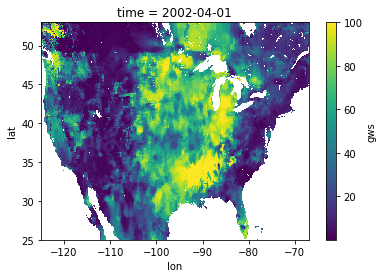

In [22]:
grace_ds['gws'].isel(time=0).plot()

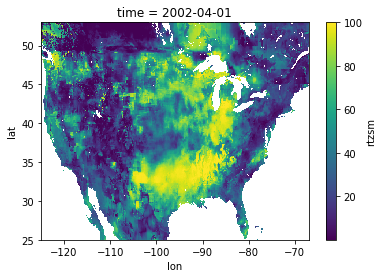

In [23]:
grace_ds['rtzsm'].isel(time=0).plot()

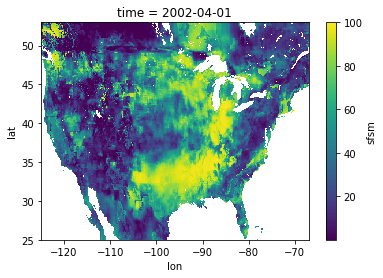

In [24]:
grace_ds['sfsm'].isel(time=0).plot()

Let's make some snapshots to check the data

years = np.arange(2002, 2023, 1)
months = np.arange(1,13,1)

fig, axs = plt.subplots(21, 12, figsize=(20, 40))

for i, year in enumerate(years):
    for j, month in enumerate(months):
        try:
            axs[i,j].set_title(f'{year}-{month}')
            grace_ds['gws'].sel(time=f'{year}-{month}').isel(time=0).plot(ax=axs[i,j], add_colorbar=False)
        except:
            print(year, month)
            pass

        axs[i,j].axis('off')

plt.tight_layout()

years = np.arange(2002, 2023, 1)
months = np.arange(1,13,1)

fig, axs = plt.subplots(21, 12, figsize=(20, 40))

for i, year in enumerate(years):
    for j, month in enumerate(months):
        try:
            axs[i,j].set_title(f'{year}-{month}')
            grace_ds['rtzsm'].sel(time=f'{year}-{month}').isel(time=0).plot(ax=axs[i,j], add_colorbar=False)
        except:
            print(year, month)
            pass

        axs[i,j].axis('off')

plt.tight_layout()

years = np.arange(2002, 2023, 1)
months = np.arange(1,13,1)

fig, axs = plt.subplots(21, 12, figsize=(20, 40))

for i, year in enumerate(years):
    for j, month in enumerate(months):
        try:
            axs[i,j].set_title(f'{year}-{month}')
            grace_ds['sfsm'].sel(time=f'{year}-{month}').isel(time=0).plot(ax=axs[i,j], add_colorbar=False)
        except:
            print(year, month)
            pass

        axs[i,j].axis('off')

plt.tight_layout()

Now to add some meta-data

In [23]:
desc = 'Percentiles of GRACE-Based percentiles of surface soil moisture, root zone soil moisture, groundwater. Data has been provided by CALMIT and NASA at their website: http://nasagrace.unl.edu/Default.aspx'

In [26]:
grace_ds.attrs = {
    'author':'a. stein, 9/1/2022',
    'description':desc,
}

In [27]:
grace_ds

<xarray.Dataset>
Dimensions:  (time: 1064, lat: 224, lon: 464)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-08 ... 2022-08-15
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
Data variables:
    gws      (time, lat, lon) float32 nan nan nan nan ... 73.55 71.57 84.14
    rtzsm    (time, lat, lon) float32 nan nan nan nan ... 64.63 62.45 78.29
    sfsm     (time, lat, lon) float32 nan nan nan nan ... 46.27 46.3 41.72 43.36
Attributes:
    author:       a. stein, 9/1/2022
    description:  Percentiles of GRACE-Based percentiles of surface soil mois...

In [29]:
grace_ds['gws'].attrs = {
    'long_name':'Groundwater Percentile',
    'standard_name':'GRACEgws',
    'units':'%'
}
grace_ds['rtzsm'].attrs = {
    'long_name':'Root Zone Soil Moisture Percentile',
    'standard_name':'GRACErtzsm',
    'units':'%'
}
grace_ds['sfsm'].attrs = {
    'long_name':'Surface Soil Moisture Percentile',
    'standard_name':'GRACEsfsm',
    'units':'%'
}

In [34]:
grace_ds.to_netcdf('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/grace/grace_us.nc')

In [2]:
grace_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/grace/grace_us.nc')

In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [4]:
wa_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
grace_var = ['gws','rtzsm', 'sfsm']

In [14]:
temp_da = grace_ds['gws']

In [16]:
grace_das = []

for var in tqdm(grace_var):
    da = grace_ds[var].rio.write_crs('EPSG:4326')
    da = da.rename({'lon':'x', 'lat':'y'})
    da_wa = wrangle.clip_xarray(da, wa_gdf).rename({'x':'lon','y':'lat'})
    grace_das.append(da_wa)

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
grace_wa_ds = xr.combine_by_coords(grace_das)

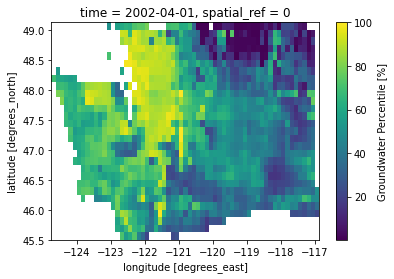

In [21]:
grace_wa_ds['gws'].isel(time=0).plot()

In [24]:
grace_wa_ds.attrs = grace_ds.attrs = {
    'author':'a. stein, 9/7/2022',
    'description':desc,
    'clipping': 'original data was clipped to Washington using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
}

In [26]:
grace_wa_ds.to_netcdf('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/grace/WA/grace_wa.nc')

Now to align with USDM and get in those categories

In [43]:
grace_usdmcat = []
percentiles = (30, 20, 10, 5, 2)

for da in grace_das:
    grace_usdmcat.append(compare.dm_to_usdmcat_multtime(da, percentiles))

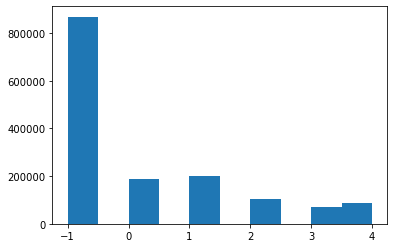

In [44]:
plt.hist(grace_usdmcat[0].values.ravel());

In [45]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [46]:
usdm_dates = pd.DatetimeIndex(usdm['date'].values)
grace_dates = pd.DatetimeIndex(grace_usdmcat[0]['time'].values)

In [47]:
pair_dates = compare.pair_to_usdm_date(usdm_dates.copy(), grace_dates.copy(), 'GRACE Date', realign=True)

/pool0/data/steinjao/drought/drought_impact/notebooks/query/../../ndrought/compare.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_dates['USDM Date'].iloc[i-1] = date
/pool0/data/steinjao/drought/drought_impact/notebooks/query/../../ndrought/compare.py:128: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pair_dates = pair_dates.dropna('index')


In [48]:
pair_dates

,GRACE Date,USDM Date
0,2002-04-01,2002-04-02 00:00:00
1,2002-04-08,2002-04-09 00:00:00
2,2002-04-15,2002-04-16 00:00:00
3,2002-04-22,2002-04-23 00:00:00
4,2002-04-29,2002-04-30 00:00:00
...,...,...
1042,2022-03-21,2022-03-22 00:00:00
1043,2022-03-28,2022-03-29 00:00:00
1044,2022-04-04,2022-04-05 00:00:00
1045,2022-04-11,2022-04-12 00:00:00


In [49]:
pair_dates['GRACE Date'].values

array(['2002-04-01T00:00:00.000000000', '2002-04-08T00:00:00.000000000',
       '2002-04-15T00:00:00.000000000', ...,
       '2022-04-04T00:00:00.000000000', '2022-04-11T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000'], dtype='datetime64[ns]')

In [50]:

for i in np.arange(len(grace_var)):
    grace_usdmcat[i] = grace_usdmcat[i].sel(time=pair_dates['GRACE Date'].values)

In [51]:
grace_usdmcat_ds = xr.combine_by_coords(grace_usdmcat)

In [53]:
grace_usdmcat_ds.attrs = {
    'author' : 'a. stein, 9/7/2022',
    'description' : 'GRACE soil moisture gathered from various time windows, (specified by the value following the underscore), categorized into USDM categories ndrought.compare.dm_to_usdmcat function.',
    'clipping' : 'Clipped to Washington state using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
}

In [54]:
grace_usdmcat_ds.to_netcdf(f'{dm_path}/grace/WA/grace_usdmcat_WA.nc')